# Cargar paquetes

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize


# Leer archivos

In [2]:
trozoC = pd.read_csv("TrozoC.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")

In [3]:
"""trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "Time"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")"""

'trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "Time"], \n                     delimiter="\t", skiprows = range(3), \n                     index_col=False, decimal=",")'

In [4]:
"""trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")"""

'trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], \n                     delimiter="\t", skiprows = range(3), \n                     index_col=False, decimal=",")'

In [5]:
trozoC.head()

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


# Establecer umbral

In [6]:
# Estrategia 1: umbral a 1.5 * rango intercuartílico
#threshold = (trozoC.quantile(0.75)-trozoC.quantile(0.25))*1.5

# Estrategia 2: umbral a media + 2 * desviación típica (donde se concentra ~95% de probabilidad de una normal)
threshold = 1.5*(trozoC[trozoC>=0].mean() + 3*trozoC[trozoC>=0].std())
print(threshold)

LP    0.383358
VD    0.196578
dtype: float64


In [7]:
def filter_with_threshold(df, threshold):
    return (df > threshold).astype(int)

In [8]:
trozoC_t = filter_with_threshold(trozoC, threshold)

El número de elementos que superan el umbral es:

In [9]:
trozoC_t.sum()

LP    125368
VD    161245
dtype: int64

In [10]:
def compare_signal_and_transformation(df, df_t, threshold):
    """
    Muestra dos señales `df` y `df_t` que tengan las mismas dimensiones.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(df_t.iloc[:,index])
        axs[index].plot(threshold[index]*np.ones(df.shape[0]))

Al aplicar la función sobre la señal original y la transformada (aplicando un escalado) podemos observar qué valores quedan por encima del umbral. Probamos con los primeros 100 valores.

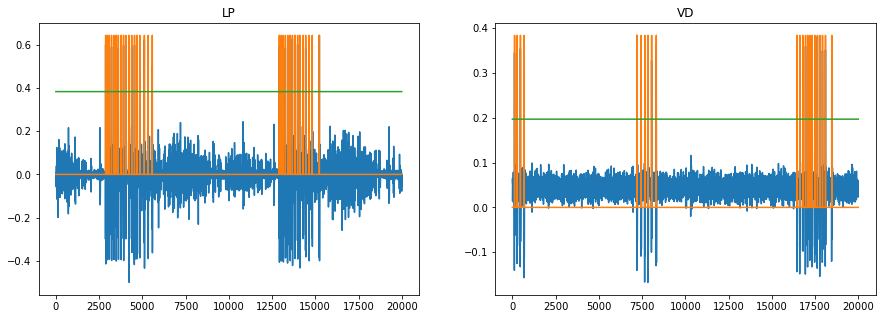

In [11]:
N=20000
compare_signal_and_transformation(trozoC[0:N], trozoC_t[0:N]*trozoC[0:N].max(), threshold)

# Calcular picos

In [12]:
def get_peaks(df):
    """
    Busca los picos correspondientes a cada columna del dataframe utilizando find_peaks. 
    Esta se queda con el valor medio de picos consecutivos.
    """
    # Get number of columns
    cols = df.shape[1] if len(df.shape) > 1 else 1
    # Initialize peaks array
    return [find_peaks(df.iloc[: , index])[0] for index in range(cols)]

El número total de picos encontrados es:

In [13]:
peaks = get_peaks(trozoC_t)
for i in peaks:
    print(len(i))

31157
22338


Ejemplo 

In [14]:
def compare_signal_and_peaks(df, peaks):
    """
    Muestra la señal original junto con los picos considerados.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(peaks[index], df.iloc[peaks[index], index], "o")

Mostramos un ejemplo en los 100 primeros valores.

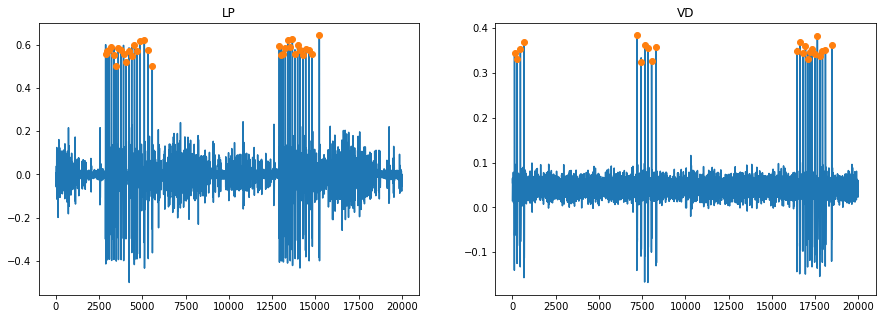

In [15]:
compare_signal_and_peaks(trozoC[0:N], get_peaks(trozoC_t[0:N]))

In [16]:
def min_distance_between_peaks(peaks):
    """
    Calcula la distancia mínima entre picos.
    """
    dist = [peaks[index + 1] - peaks[index] for index in range(len(peaks)-1)]
    return min(dist), dist.index(min(dist))

In [17]:
peaks = get_peaks(trozoC_t)
min_dist = [min_distance_between_peaks(a) for a in peaks]
print("Distancia mínima y pico donde se alcanza: ", min_dist)
window = min([a[0] for a in min_dist])
print("Ventana seleccionada: ", window)
min_peak_position = [a[1] for a in min_dist]
min_peak_position = [[peaks[idx][min_peak_position[idx]], peaks[idx][min_peak_position[idx]+1]] 
                     for idx in range(len(peaks))]
print("Posiciones de los picos mas cercanos: ", min_peak_position)

Distancia mínima y pico donde se alcanza:  [(23, 3570), (5, 13312)]
Ventana seleccionada:  5
Posiciones de los picos mas cercanos:  [[2142183, 2142206], [12346213, 12346218]]


In [18]:
def plot_window(df, window, peak_position):
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[peak_position[index][0]-50:peak_position[index][1]+50, index])        
        axs[index].plot(peak_position[index][0], df.iloc[peak_position[index][0], index], "o")
        axs[index].plot(peak_position[index][1], df.iloc[peak_position[index][1], index], "o")
        xlims = [int(np.round(a)) for a in axs[index].get_xlim()]
        offset = int(window* np.round(xlims[0]/window)) 
        axs[index].vlines([ offset + idx for idx in range(0,xlims[1]-xlims[0], window)], *axs[index].get_ylim())
        

Mostramos la rejilla alrededor de los dos picos mas cercanos de la primera serie temporal

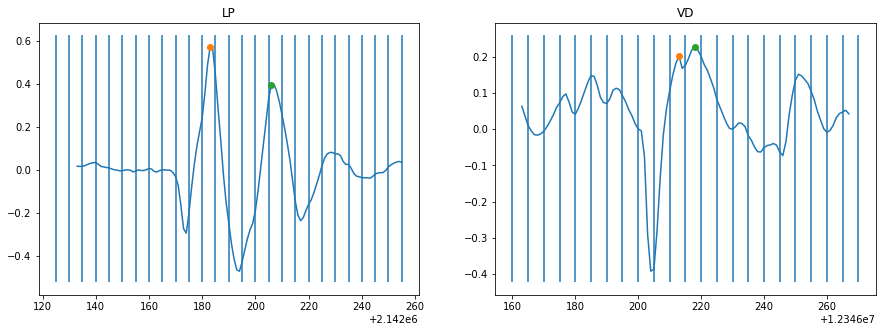

In [19]:
plot_window(trozoC, window, min_peak_position)

In [47]:
def apply_window(lenght, peaks, window):
    """
    Crea un vector de 0's y 1's representando la existencia de una señal en la 
    ventana prefijada de una serie temporal.
    Argumentos:
    - lenght: Longitud de la serie temporal.
    - peaks: posicion de las señales en la serie temporal.
    - window: tamaño de ventana.
    """
    # Crea vector de 0 con longitud adecuada (el entero inmediato superior a lenght/window). 
    # Por ejemplo, si la señal es de tamaño 1000 y la ventana 3, el resultado tiene tamaño 334.
    aux = np.zeros(math.ceil(lenght/window))
    # Toma los indices correspondientes a cada pico tras aplciar la ventana.
    # Por ejemplo, si hay un pico en la posición 100 y la ventana es 3, el pico pasaría a estar en la 
    #   posición 33.
    indexes = [math.floor(n/window) for n in peaks]
    # Señala los picos.
    aux[indexes] = 1
    return aux
    
trozoC_w = np.array([apply_window(trozoC.shape[0], peaks[idx], window) for idx in range(trozoC.shape[1])])

In [48]:
len(trozoC_w[0])

3969540

In [49]:
trozoC_w[1,:]

array([0., 0., 0., ..., 0., 0., 0.])

# Cómputo de información mutua

In [120]:
def get_states_probabilities(array, bits):
    aux = np.array([array[:,i:i+bits] for i in range(array.shape[1]-bits)])

    uniquej, countsj = np.unique(aux, axis = 0, return_counts=True)
    unique0, counts0 = np.unique(aux[:,0], axis = 0, return_counts=True)
    unique1, counts1 = np.unique(aux[:,1], axis = 0, return_counts=True)
    
    
    return uniquej, countsj/np.sum(countsj) ,unique0, counts0/np.sum(counts0), unique1, counts1/np.sum(counts1)

In [121]:
def MI(a, b, c):
    return np.sum( [ [a[j+2*i] * np.log2(a[j+2*i]/(b[i]*c[j]))  
                for i in range(len(b))] for j in range(len(c))])

In [122]:
def full_compute(df, bits):
    _, probs_j, _, probs_0, _, probs_1 = get_states_probabilities(df, bits)
    return(MI(probs_j, probs_0, probs_1))

In [123]:
full_compute(trozoC_w, 1)

5.22331926527872e-05

In [124]:
full_compute(trozoC_w, 2)

0.22027236230868502

In [125]:
full_compute(trozoC_w, 3)

0.585071358912537

In [126]:
full_compute(trozoC_w, 4)

1.1821055647975904